<a href="https://colab.research.google.com/github/DiploDatos/AnalisisYCuracion/blob/master/08_Encodings_para_texto_y_LDA_%5BOpcional%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Exploración y Curación de Datos**

*Edición 2021*

----

# Encodings para texto y LDA

En esta notebook, utilizaremos el conjunto de datos **resultado** de la notebook `03 Combinación por coordenadas.ipynb`, que contiene los datos de ventas de propiedades en Melbourne de [esta compentencia de Kaggle](https://www.kaggle.com/dansbecker/melbourne-housing-snapshot), al cual se le agregó una columna con las descripciones del vencidario extraídas de [un conjunto de datos de scrapings](https://www.kaggle.com/tylerx/melbourne-airbnb-open-data?select=cleansed_listings_dec18.csv) de publicaciones de AirBnB.

In [10]:
import matplotlib.pyplot as plt
import numpy
import pandas

import seaborn
seaborn.set_context('talk')

In [11]:
# This allows us to print more information per column
pandas.set_option('display.max_colwidth', 500)

In [12]:
melb_df = pandas.read_csv(
    'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/melb_extended_neighborhood_overview.csv')
melb_df.sample(3)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,closest_airbnb_neighborhood_overview
5491,Seddon,15 Pentland Pde,4,h,1201000.0,S,Village,10/12/2016,6.6,3011.0,4.0,2.0,1.0,299.0,158.0,1910.0,Maribyrnong,-37.80870,144.8952,Western Metropolitan,2417.0,"Seddon has been labelled the 'new Brunswick', with plenty of nice cafes, eateries and shops around. Just up the road is Footscray with markets and many an international eatery, or in the opposite direction, Yarraville, where you can go to the cinema or for a more western bite. Our suburb is mostly populated by younger people and uni students, so it would definitely suit the younger crowd.\nWalk to the quaint villages of Seddon and Yarraville, which are a stone's throw away and are filled wit..."
13410,Eltham North,45 Allison Cr,4,h,905000.0,S,Buckingham,26/08/2017,18.0,3095.0,4.0,2.0,0.0,2000.0,153.0,1975.0,NaN,-37.70232,145.1419,Eastern Metropolitan,2346.0,"Peace and tranquility on a large allotment in an elevated position is an escape from the hussle and bussle of the City, yet close enough (20kms or 30 minutes) to travel to see the sights. Good access to the Ring Road and airport.\nSet on the high side of the road, Kerrie Crescent is a lovely windy, unsealed lane and remains one of Eltham's little treasures.\n\nOUR NEIGHBOURHOOD IS A SMALL ESTATE WITH 51 HOUSES. OUR NEIGHBOURS ALL RESPECT EACH OTHER.WE LIVE ON TOP OF A HILL WITH SOME LOVELY V..."
5274,Richmond,32 Jubilee Pl,2,h,1042500.0,S,hockingstuart,4/03/2017,2.6,3121.0,2.0,1.0,1.0,80.0,NaN,NaN,Yarra,-37.81260,145.0040,Northern Metropolitan,14949.0,"The neighbourhood is fairly quiet and yet many restaurants, shops and cafes are within walking distance, with many casual and local Asian restaurants and pubs.\nJust around the corner from the Vietnamese District (Victoria Street) which has lots of yummy foods to try. There are also a lot of Bars and Cafe's in the neighbourhood. The tram around the corner can get to sunny St Kilda Beach. Richmond is close to East Melbourne, Fitzroy and Collingwood which also have popular attractions and nig..."


## Explorando texto libre

Los datos no estructurados, como el texto libre o las imágenes, tienen métodos específicos para poder analizarlos. En este notebook trataremos de entender qué tipo de información nos aportan las descripciones de los vecindarios, y si puede ser de utilidad en nuestra tarea de predicción de precios.

El útil saber qué cantidad de texto tenemos por instancia, para comenzar a estimar la cantidad de información representada y algunas características de los documentos. Por ejemplo: no es lo analizar Tweets que analizar documentos de la wikipedia.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Distribution of number of characters for neighborhood reviews')

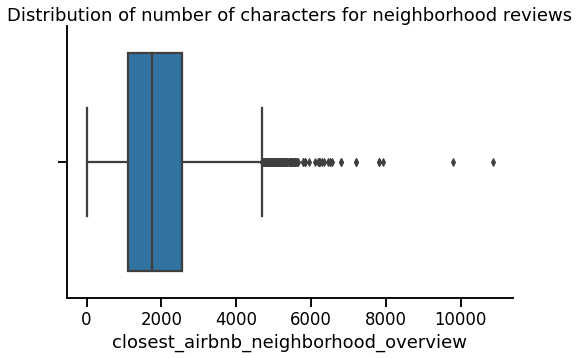

In [13]:
plt.figure(figsize=(8, 5))
seaborn.boxplot(melb_df.closest_airbnb_neighborhood_overview.apply(len))
seaborn.despine()
plt.title("Distribution of number of characters for neighborhood reviews")

## Análisis de frecuencias de palabras

### Nubes de palabras por CouncilArea

Una buena representación visual para entender de qué "habla" un texto son las nubes de palabras. 

In [14]:
def sample_text_from_col(df, n=100,
                         text_col='closest_airbnb_neighborhood_overview'):
  """Extract a sample of text from column"""
  if n > len(df):
    n = len(df)
  return '\n'.join(df.sample(n)[text_col].values)

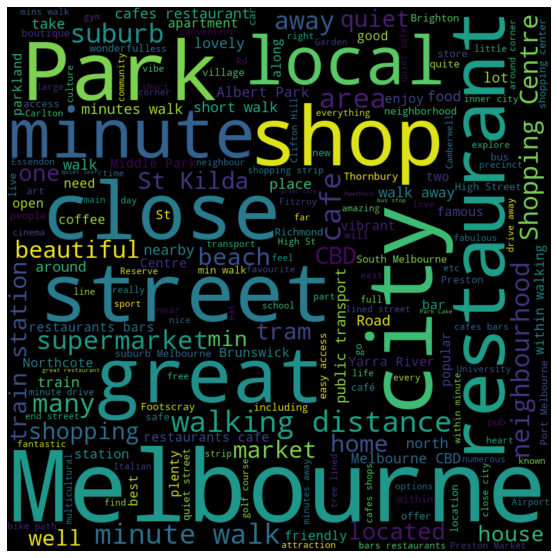

In [15]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

text_sample = sample_text_from_col(melb_df)
wc = WordCloud(width=900, height=900, max_font_size=200).generate(text_sample)
plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Podemos ahora crear nubes de palabras para las descripciones de CouncilArea

In [ ]:
unique_council_areas = melb_df.CouncilArea.unique()
text_samples_for_areas = {
    area: sample_text_from_col(melb_df[melb_df.CouncilArea == area])
    for area in unique_council_areas
    if isinstance(area, str)
}
list(text_samples_for_areas.keys())

['Yarra',
 'Moonee Valley',
 'Port Phillip',
 'Darebin',
 'Hobsons Bay',
 'Stonnington',
 'Boroondara',
 'Monash',
 'Glen Eira',
 'Whitehorse',
 'Maribyrnong',
 'Bayside',
 'Moreland',
 'Manningham',
 'Banyule',
 'Melbourne',
 'Kingston',
 'Brimbank',
 'Hume',
 'Knox',
 'Maroondah',
 'Casey',
 'Melton',
 'Greater Dandenong',
 'Nillumbik',
 'Whittlesea',
 'Frankston',
 'Macedon Ranges',
 'Yarra Ranges',
 'Wyndham',
 'Cardinia',
 'Unavailable',
 'Moorabool']

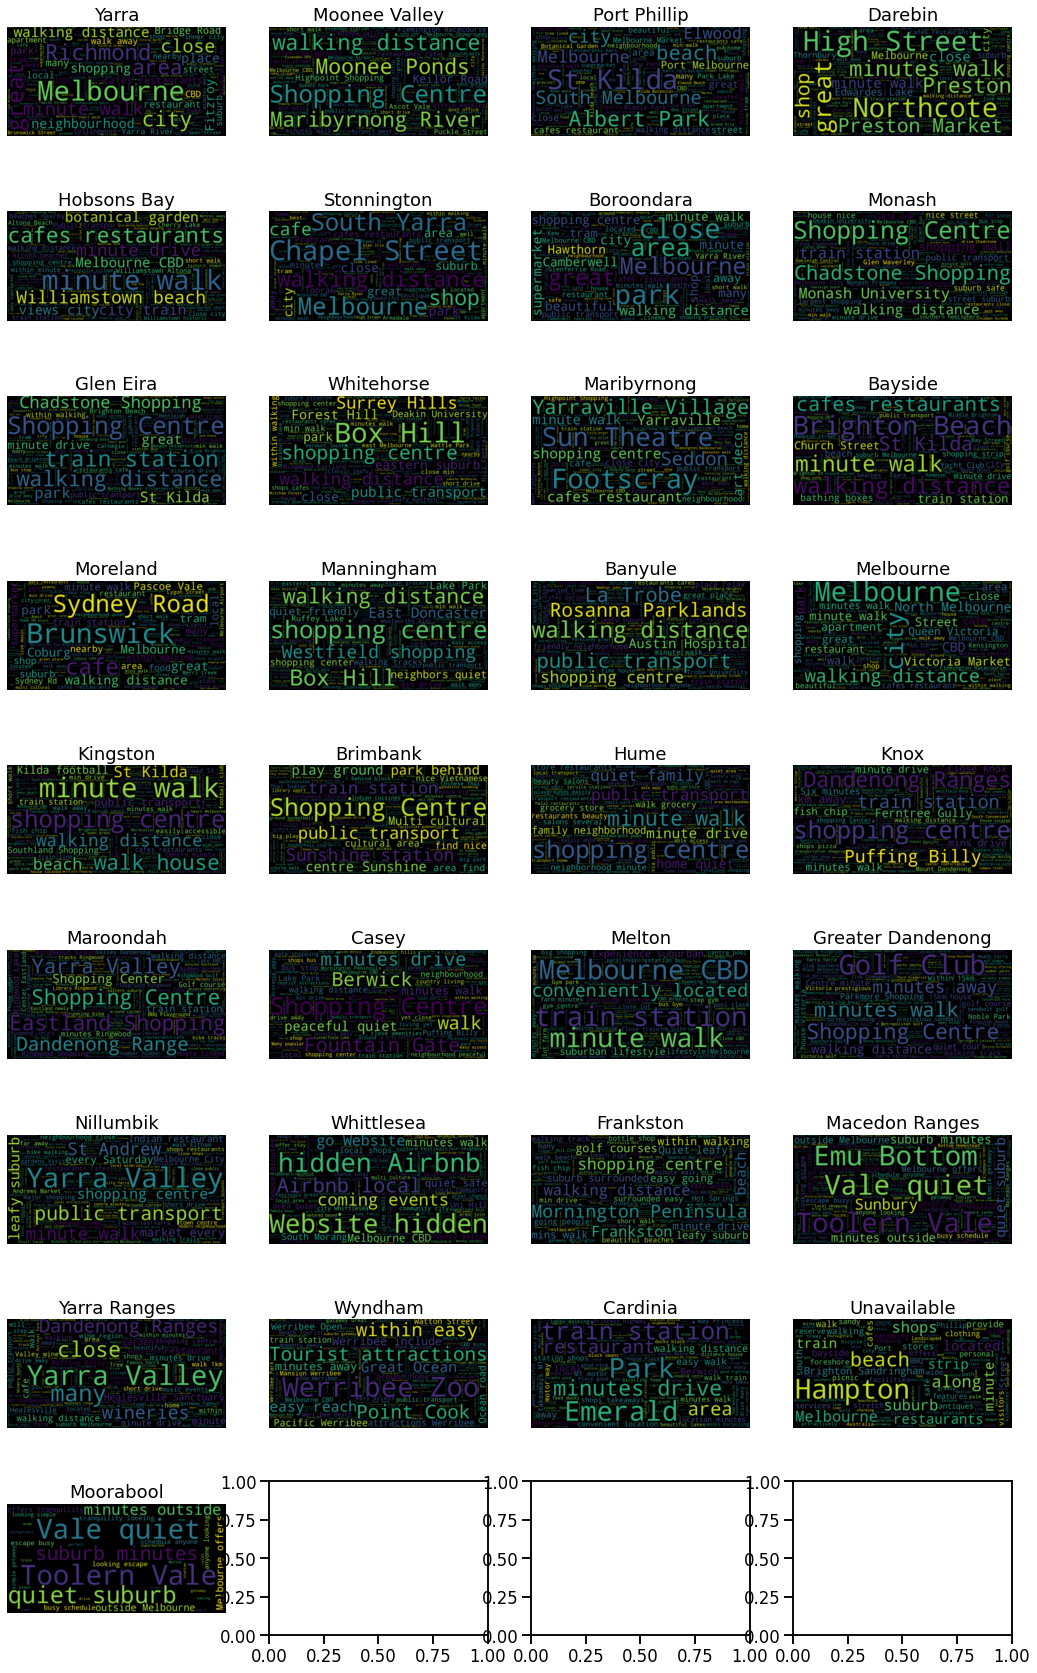

In [ ]:
# Create general layout
n_cols = 4
n_rows = math.ceil(len(text_samples_for_areas) / n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(18, 30))
for i, (area, text_sample) in enumerate(text_samples_for_areas.items()):
  wc = WordCloud(width=600, height=300, max_font_size=200)\
      .generate(text_sample)
  row = math.floor(i / n_cols)
  col = i % n_cols
  ax = axs[row, col]
  ax.imshow(wc, interpolation='bilinear')
  ax.axis("off")
  ax.set_title(area)

## Codificación de variables con texto libre

Si bien las nubes de palabras son muy intuitivas, no podemos usarlas para realizar análisis numéricos. De la misma forma que los datos categóricos, los datos textuales necesitan ser codificados en vectores.

En esta mini-introducción utilizaremos un encoding de *bolsa de palabras* o bag-of-words en Inglés. Sean:
1. $W$ el conjunto de palabras llamado *vocabulario*, y sea $M = |W|$ su tamaño. Es decir, existen $M$ palabras distintas en nuestros documentos.
2. $w_i \in W $ la palabra número $i$ del vocabulario.

Utilizando la clase `CountVectorizer` de scikit-learn, se proyecta el document a un vector $v \in \mathbb{R}^{M}$ donde cada columna $i$ se rellena con el número de veces en las que cada palabra $w_i$ ocurren en el documento.

Para evitar una explosión de dimensiones, limitaremos el tamaño del vocabulario sólo a las palabras más frecuentes. Además de ello, las palabras más frecuentes de un idioma, como "él", "de", son muy poco informativas. Se las denomina *stopwords*. Por ello, generalmente se ignoran en este tipo de representaciones. 

Nota: Esta representación es una de las más simples de obtener, sin embargo, existen otras proyecciones más adecuadas.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
vocab_size = 500  ## Only 500 most frequent words
vectorizer = CountVectorizer(max_features=vocab_size, stop_words='english')
tokens = vectorizer.fit_transform(melb_df.closest_airbnb_neighborhood_overview)

In [ ]:
vectorizer.get_feature_names()[:10]

['10', '11', '12', '15', '1km', '20', '25', '30', '5km', 'access']

In [ ]:
tokens.shape

(13580, 500)

Podemos ver la frecuencia de cada palabra

In [ ]:
word_frequencies = pandas.DataFrame(
    data={'frequency': tokens.sum(axis=0).flatten().tolist()[0],
                                     'tokens': vectorizer.get_feature_names()})
word_frequencies.sort_values('frequency')

,frequency,tokens
492,916,woolworth
113,916,cuisine
132,917,doncaster
94,917,clothing
466,919,use
...,...,...
65,29747,cafes
394,30963,shopping
373,31122,restaurants
479,39023,walk


## Reducción de dimensionalidad

Los vectores que representan cada uno de nuestros comentarios no nos sirven para poder entender los datos, porque no podemos pensar en cientos de dimensiones al mismo tiempo. Son demasiado *antiintuitivos*.

Podemos intentar aplicar un método como PCA para reducir la dimensionalidad de los vectores, pero esto no nos devolverá vectores que nosotros podamos leer o entender.

Por suerte, existen formas de transformarlos en representaciones que sean más *human-friendly*.

[LDA](https://scikit-learn.org/stable/modules/decomposition.html?highlight=lda#latent-dirichlet-allocation-lda) o Latent Dirichlet Allocation es un modelo que asume que cada texto habla de un tema o *topic* desconocido.

Cuando es entrenado, encuentra grupos de palabras (vectores) que corresponden a los topics que mejor explicarían los datos.


In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification

lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(tokens)

In [ ]:
lda.components_

array([[3015.06143567,   62.82532619,  456.57621896, ...,  192.63185845,
         231.88848442,    8.42601304],
       [2079.81220916,  218.50931868,  178.22770008, ...,  289.85760683,
         672.92091467,  812.5746923 ],
       [4312.44048363,  464.68065737,  346.14242396, ...,  197.39573469,
          95.89438469,  212.21665021],
       [1800.30404957,  212.86351659,  207.63139762, ...,  144.64161377,
         218.90033053,   14.7983414 ],
       [1968.38182197,  179.12118117,   70.42225938, ...,  279.47318626,
         199.3958857 ,  482.98430305]])

In [ ]:
feature_names = vectorizer.get_feature_names()
feature_names[:3]

['10', '11', '12']

In [ ]:
def plot_top_words(model, feature_names, n_top_words=10, title=''):
    n_cols = 2
    n_rows = math.ceil(model.n_components / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

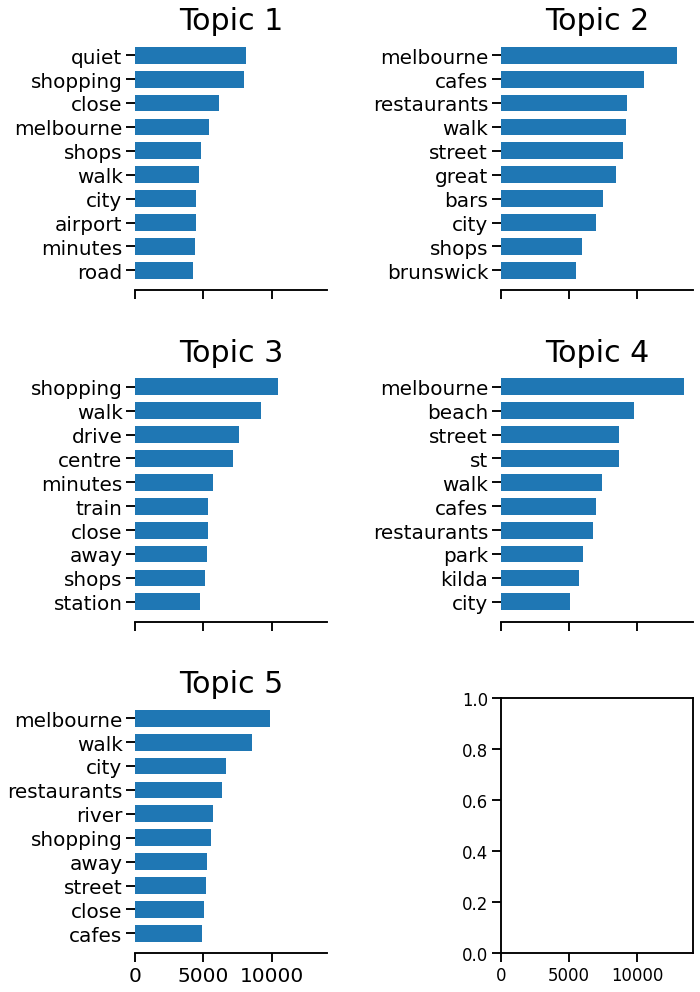

In [ ]:
plot_top_words(lda, feature_names)

Ahora podemos utilizar el modelo para determinar cuál es la probabilidad de que un texto sea generado por ese topia. Es decir, "qué tanto del tema X habla el documento".

In [ ]:
lda_columns = ['topic{}'.format(i) for i in range(lda.n_components)]
melb_df[lda_columns] = lda.transform(tokens)

In [ ]:
melb_df[['closest_airbnb_neighborhood_overview'] + lda_columns].sample()

,closest_airbnb_neighborhood_overview,topic0,topic1,topic2,topic3,topic4
4156,"\n* Our house is located in a very small, quiet and safe court in the bayside suburb of Moorabbin, with no through traffic, so you are undisturbed by traffic noise. * The local shopping centre and cafes is 10 minute's walk from the house * The large Southland (Westfield) Shopping Centre is 2.6Km away and easily accessible by a bus which is a few minutes walk from our home. Chadstone is a bus ride away. * Brighton Beach is 6Km from the house and easily accessed by public transport, where you can enjoy a walk or swim, or a meal of fish and chips on the foreshore. * Monash University ( both Clayton and Caulfield campuses) is 11Km and easily accessible by public transport. * The Keys Road Training Centre is a 15 minute walk from the house. * Holmesglen TAFE is 5 minute's walk from the house. * The Highett train station is 15 minute's walk from the house, and the train line runs from the city through the beachside suburbs as far as Frankston. * The house is within easy walking distance ...",0.001049,0.00104,0.934488,0.06238,0.001043


Ahora podemos ver las correlaciones entre los topics y el resto de las variables en nuestro conjunto de datos. Podemos ver que existe una cierta correlación entre el primer topic con algunos de los valores posibles para CouncilArea

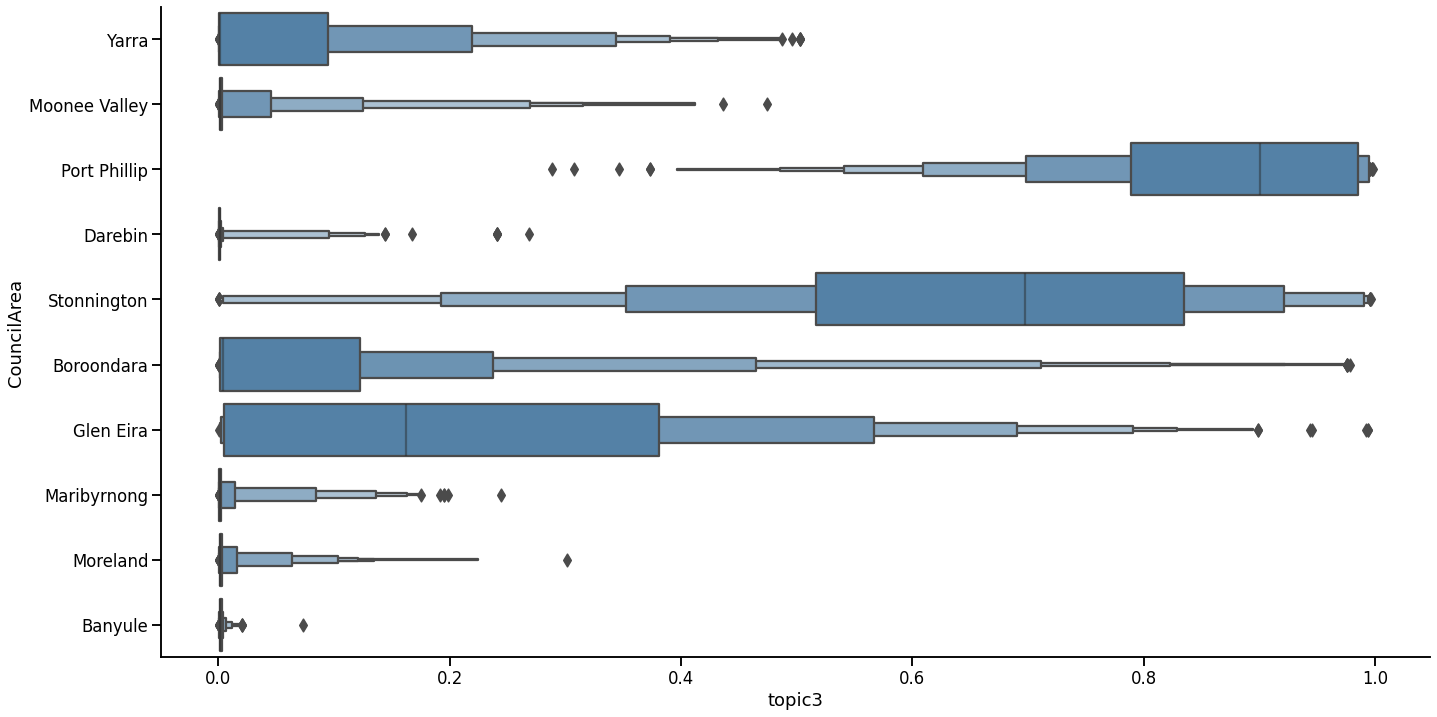

In [ ]:
most_common_areas = melb_df.CouncilArea.value_counts()[:10].index
seaborn.catplot(data=melb_df[melb_df.CouncilArea.isin(most_common_areas)],
                x='topic3', y='CouncilArea', kind='boxen',
                height=10, aspect=2, color='steelblue')

¿Nos sirve para poder estimar mejor el precio de una propiedad? Si graficamos la distribución de precios para cada topic (tomando sólo el topic más probable para cada documento), no observamos mucha variabilidad.

In [ ]:
melb_df['most_likely_topic'] = melb_df[lda_columns].values.argmax(axis=1)
melb_df[lda_columns + ['most_likely_topic']].head()

,topic0,topic1,topic2,topic3,topic4,most_likely_topic
0,0.000458,0.239827,0.048415,0.000457,0.710844,4
1,0.000307,0.477759,0.000308,0.044790,0.476835,1
2,0.000295,0.594901,0.000295,0.082541,0.321968,1
3,0.025602,0.191831,0.105826,0.000408,0.676333,4
4,0.000379,0.515925,0.000381,0.000382,0.482933,1


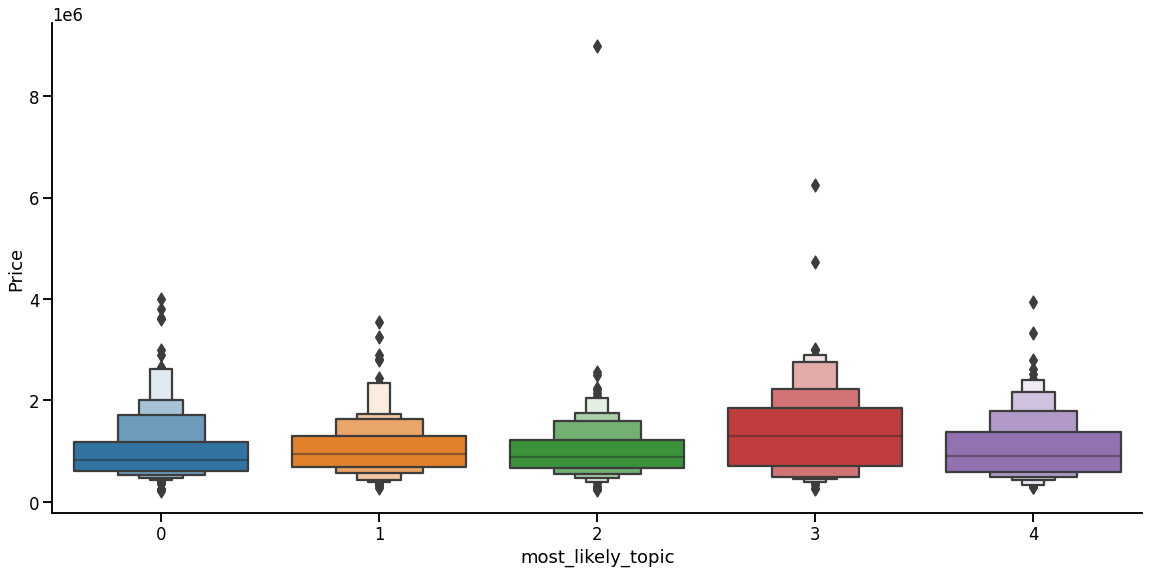

In [ ]:
seaborn.catplot(data=melb_df.sample(1000),
                x='most_likely_topic', y='Price',# hue='Type',
                kind='boxen',
                height=8, aspect=2)

**Ejercicio:** Projectar la columna con descripciones textuales con PCA y graficar las dos primeras componentes.
